In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import abel

In [2]:
def tri_area(p1,p2,p3):
    area = 0.5*np.abs(p1[0]*p2[1]+p2[0]*p3[1]+p3[0]*p1[1]-p2[0]*p1[1]-p3[0]*p2[1]-p1[0]*p3[1]) #Shoelace formula
    return area

In [3]:
#Pixel and corresponding line of sight
#Assume 
class Image:
    def __init__(self,img,pixelsize):
        self.img = img
        self.size = np.shape(img)
        self.pixelsize = pixelsize
        self.pixels = self.set_pixels()
        self.boundaries = self.get_boundaries()
        
    def set_pixels(self):
        pixels = []
        for i in range(self.size[0]):
                pixels.append(Pixel(self.img[i],i,self.size[0],self.pixelsize))
        return pixels
    
    def get_boundaries(self):
        boundaries = np.zeros(self.size[0]+1)
        for i in range(self.size[0]):
            boundaries[i] = self.pixels[i].upper_boundary
        boundaries[self.size[0]] = self.pixels[-1].lower_boundary
        return boundaries
                
class Pixel:
    
    def __init__(self,value,index,imgsize,width):
        self.value = value
        self.index = index
        self.lower_boundary, self.upper_boundary = self.get_boundaries(imgsize,width)
        
    def get_boundaries(self,imgsize,width): #Coordinate boundaries of centered image, assume odd number of pixels
        #center = int(imgsize/2)
        #upper_boundary = (center-self.index+0.5)*width
        #lower_boundary = (center-self.index-0.5)*width
        upper_boundary = (imgsize-self.index)*width
        lower_boundary = (imgsize-self.index-1)*width
        return lower_boundary, upper_boundary    

In [4]:
#Circular isolines in the right half-plane
class Isolines:
    
    def __init__(self,r_min,r_max,N,M):
        #self.R = np.linspace(r_min,r_max,N)
        self.R = np.sqrt(np.linspace(r_min,r_max,N))
        self.number_of_lines = N
        self.number_of_points_per_line = M
        self.phi_min = 0
        self.phi_max = np.pi/2
        self.sample_points_polar = np.empty((0,2))
        self.sample_points_cartesian = np.empty((0,2))
        self.triangles = None
        self.triangle_areas = None
        self.triangle_cuts = dict()
                
    def sample(self):
        sample_points = [[0,0]] #origin r = 0, phi = 0
        for r in self.R[1:]:
            angles = np.linspace(self.phi_min,self.phi_max,self.number_of_points_per_line)
            sample_points.extend([r,phi] for phi in angles) #fix later, extend is slow
        self.sample_points_polar = np.array(sample_points)
        self.get_cartesian()
    
    def triangulate(self):
        self.triangles = tri.Triangulation(self.sample_points_cartesian[:,0], self.sample_points_cartesian[:,1])
        
    def calculate_matrix_elements(self,image):
        matrix = np.zeros((image.size[0],self.number_of_lines))
        self.calculate_triangle_areas()
        self.group_by_isolines()
        self.group_by_pixels(image)
        for i in range(self.triangles.triangles.shape[0]):
            m = self.pixel_indices[i]
            n = self.isoline_indices[i]
            if isinstance(m,list):
                if "D" in m:
                    m = m[0]
                    for j in n:
                        k=0
                        while k < (m[1]-m[0]):
                            matrix[m[0]+k,j] += 1/3.0*(self.triangle_cuts[i][k]-self.triangle_cuts[i][k+1])
                            k+=1
                        matrix[m[1],j] += 1/3.0*(self.triangle_cuts[i][k])
                elif "U" in m:
                    m = m[0]
                    for j in n:
                        k=0
                        while k < (m[1]-m[0]):
                            matrix[m[1]-k,j] += 1/3.0*(self.triangle_cuts[i][k]-self.triangle_cuts[i][k+1])
                            k+=1
                        matrix[m[0],j] += 1/3.0*(self.triangle_cuts[i][k])
                elif "E" in m:
                    m = m[0]
                    for j in n:
                        matrix[m[0],j] += 1/3.0*(self.triangle_cuts[i][0])
                        matrix[m[1],j] += 1/3.0*(self.triangle_cuts[i][1][0]-self.triangle_cuts[i][1][1]-self.triangle_cuts[i][0])
                        k=1
                        while k<(m[2]-m[1]):
                            matrix[m[1]+k,j] += 1/3.0*(self.triangle_cuts[i][1][k]-self.triangle_cuts[i][1][k+1])
                            k+=1
                        matrix[m[2],j] += 1/3.0*(self.triangle_cuts[i][1][k])
                else:
                    if len(m)==2:
                        for j in n:
                            matrix[m[0],j] += 1/3.0*(self.triangle_cuts[i])
                            matrix[m[1],j] += 1/3.0*(self.triangle_areas[i] - self.triangle_cuts[i])
                    else:
                        for j in n:
                            matrix[m[0],j] += 1/3.0*(self.triangle_cuts[i][0])
                            matrix[m[1],j] += 1/3.0*(self.triangle_areas[i]-self.triangle_cuts[i][0]-self.triangle_cuts[i][1])
                            matrix[m[2],j] += 1/3.0*(self.triangle_cuts[i][1])
            else:
                for j in n:
                    matrix[m,j] += 1/3.0*(self.triangle_areas[i])
        return 2*matrix/image.pixelsize
        
        
    def calculate_triangle_areas(self):
        self.triangle_areas = np.zeros(self.triangles.triangles.shape[0])
        for i in range(self.triangles.triangles.shape[0]):
            self.triangle_areas[i] = tri_area(*self.sample_points_cartesian[self.triangles.triangles[i]])
    
    def group_by_isolines(self):
        self.isoline_indices = [None] * self.triangles.triangles.shape[0]
        for i in range(self.triangles.triangles.shape[0]):
            radii = self.sample_points_polar[self.triangles.triangles[i]][:,0]
            #base attribution scheme
            #unique, counts = np.unique(radii, return_counts=True)
            #attributed_radius = unique[counts==2][0]
            #self.isoline_indices[i] = int((self.number_of_lines-1) * attributed_radius/(self.R[self.number_of_lines-1]-self.R[0]))
            
            #simple average scheme
            #indices = (self.number_of_lines-1) * radii/(self.R[self.number_of_lines-1]-self.R[0]) #uniform
            indices = (self.number_of_lines-1) * radii**2 #non-uniform
            self.isoline_indices[i] = list(map(round,indices))
            
            
    def group_by_pixels(self,image):
        self.pixel_indices = [None] * self.triangles.triangles.shape[0]
        for i in range(self.triangles.triangles.shape[0]):
            self.pixel_indices[i] = self.find_pixel(i, self.triangles.triangles[i], image)
        
    def find_pixel(self, triangle_index, triangle, image):
        y_coords = self.sample_points_cartesian[triangle][:,1]
        bounds = -image.boundaries #flip order from descending to ascending
        indices = np.searchsorted(bounds,-y_coords) #flip sign as above
        indices = np.where(indices != 0, indices, 1)
        unique_indices, index_positions, counts = np.unique(indices,return_index=True,return_counts=True)
        if unique_indices.shape[0]==1:
            return unique_indices[0]-1
        elif unique_indices.shape[0] == 2:
            if unique_indices[1]-unique_indices[0] > 1:
                #print(triangle_index,"Error1") #If that error occurs, increase M
                tip_pos = index_positions[counts==1][0]
                areas = self.cut_by_multiple_pixels(triangle_index, triangle, unique_indices, tip_pos, image)
                self.triangle_cuts.update({triangle_index:areas})
                if indices[tip_pos] == np.max(indices):
                    return [list(unique_indices-1),"D"]
                else:
                    return [list(unique_indices-1),"U"]
            else:
                tip_pos = index_positions[counts==1][0]
                area = self.cut_by_pixel(triangle_index, triangle, unique_indices[0], tip_pos, image) #cut by pixel and calculate area of subtriangle
                self.triangle_cuts.update({triangle_index:area})
                return [unique_indices[counts==1][0]-1,unique_indices[counts==2][0]-1] #put tip index first so that the mapping of the subarea to the pixel is clear and doesn't need to be stored as extra information
        else:
            #return 0
            if np.any(np.diff(unique_indices)>1):
                #print("Error") #If that error occurs, increase M
                tip_pos_high = np.argmin(indices) 
                tip_pos_low = np.argmax(indices)
                area1 = self.cut_by_pixel(triangle_index, triangle, unique_indices[0], tip_pos_high, image)
                areas2 = self.cut_by_multiple_pixels(triangle_index, triangle, unique_indices, tip_pos_low, image)
                self.triangle_cuts.update({triangle_index:[area1,areas2]})
                return [list(unique_indices-1),"E"]
                
            else:
                tip_pos1 = index_positions[0]
                tip_pos2 = index_positions[2]
                area1 = self.cut_by_pixel(triangle_index, triangle, unique_indices[0], tip_pos1, image)
                area2 = self.cut_by_pixel(triangle_index, triangle, unique_indices[1], tip_pos2, image)
                #print((self.triangle_areas[triangle_index]-area1-area2)/self.triangle_areas[triangle_index]*100)
                self.triangle_cuts.update({triangle_index:[area1,area2]})
                return list(unique_indices-1)
        
    def cut_by_pixel(self, triangle_index, triangle, border_index, tip_pos, image):
        #Identify tip point and base points
        mask = np.ones(3,bool)
        mask[tip_pos] = False
        tip = self.sample_points_cartesian[triangle][tip_pos]
        base1 = self.sample_points_cartesian[triangle][mask][0]
        base2 = self.sample_points_cartesian[triangle][mask][1]
        
        #Calculate intersection points
        bound = image.boundaries[border_index]
        t1 = (bound - base1[1])/(tip[1]-base1[1])
        t2 = (bound - base2[1])/(tip[1]-base2[1])
        p1 = np.array([t1 * tip[0] + (1-t1) * base1[0],bound])
        p2 = np.array([t2 * tip[0] + (1-t2) * base2[0],bound])
        
        #calculate area of tip-intersection-intersection triangle
        return tri_area(tip,p1,p2)
    
    def cut_by_multiple_pixels(self, triangle_index, triangle, unique_indices, tip_pos, image):
        #Move from largest to smallest triangle
        #Identify tip point and base points
        mask = np.ones(3,bool)
        mask[tip_pos] = False
        tip = self.sample_points_cartesian[triangle][tip_pos]
        base1 = self.sample_points_cartesian[triangle][mask][0]
        base2 = self.sample_points_cartesian[triangle][mask][1]
        sign = round(np.sign(base2[1]-tip[1]))
        if unique_indices.shape[0]==2: 
            if sign>0:
                border_index = unique_indices[0]
            else:
                border_index = unique_indices[1]-1
            diff = unique_indices[1]-unique_indices[0]
        else:
            if sign>0:
                border_index = unique_indices[0]+1
            else:
                print("warning")
            diff = unique_indices[2]-unique_indices[1]
        #proxy triangle areas
        proxy_area = [[]]*(diff+1)
        k=0
        proxy_area[k] = tri_area(tip,base1,base2)
        while k < diff:
            #Calculate intersection points
            bound = image.boundaries[border_index]
            t1 = (bound - base1[1])/(tip[1]-base1[1])
            t2 = (bound - base2[1])/(tip[1]-base2[1])
            p1 = np.array([t1 * tip[0] + (1-t1) * base1[0],bound])
            p2 = np.array([t2 * tip[0] + (1-t2) * base2[0],bound])
            base1 = p1
            base2 = p2
            
            k+=1
            border_index+=1*sign
            #calculate area of tip-intersection-intersection triangle
            proxy_area[k] = tri_area(tip,base1,base2)
        #print(proxy_area)
        return proxy_area

    def get_cartesian(self):
        self.sample_points_cartesian = np.zeros((self.sample_points_polar.shape[0],2))
        for i in range(self.sample_points_polar.shape[0]):
            r = self.sample_points_polar[i][0]
            phi = self.sample_points_polar[i][1]
            self.sample_points_cartesian[i][0] = r*np.cos(phi)
            self.sample_points_cartesian[i][1] = r*np.sin(phi)

In [43]:
N=10
M=50
frame = Image(np.zeros(N),1.0/N)
circs = Isolines(0,1,N,M)
circs.sample()
circs.triangulate()
P = circs.sample_points_cartesian
I = circs.calculate_matrix_elements(frame)

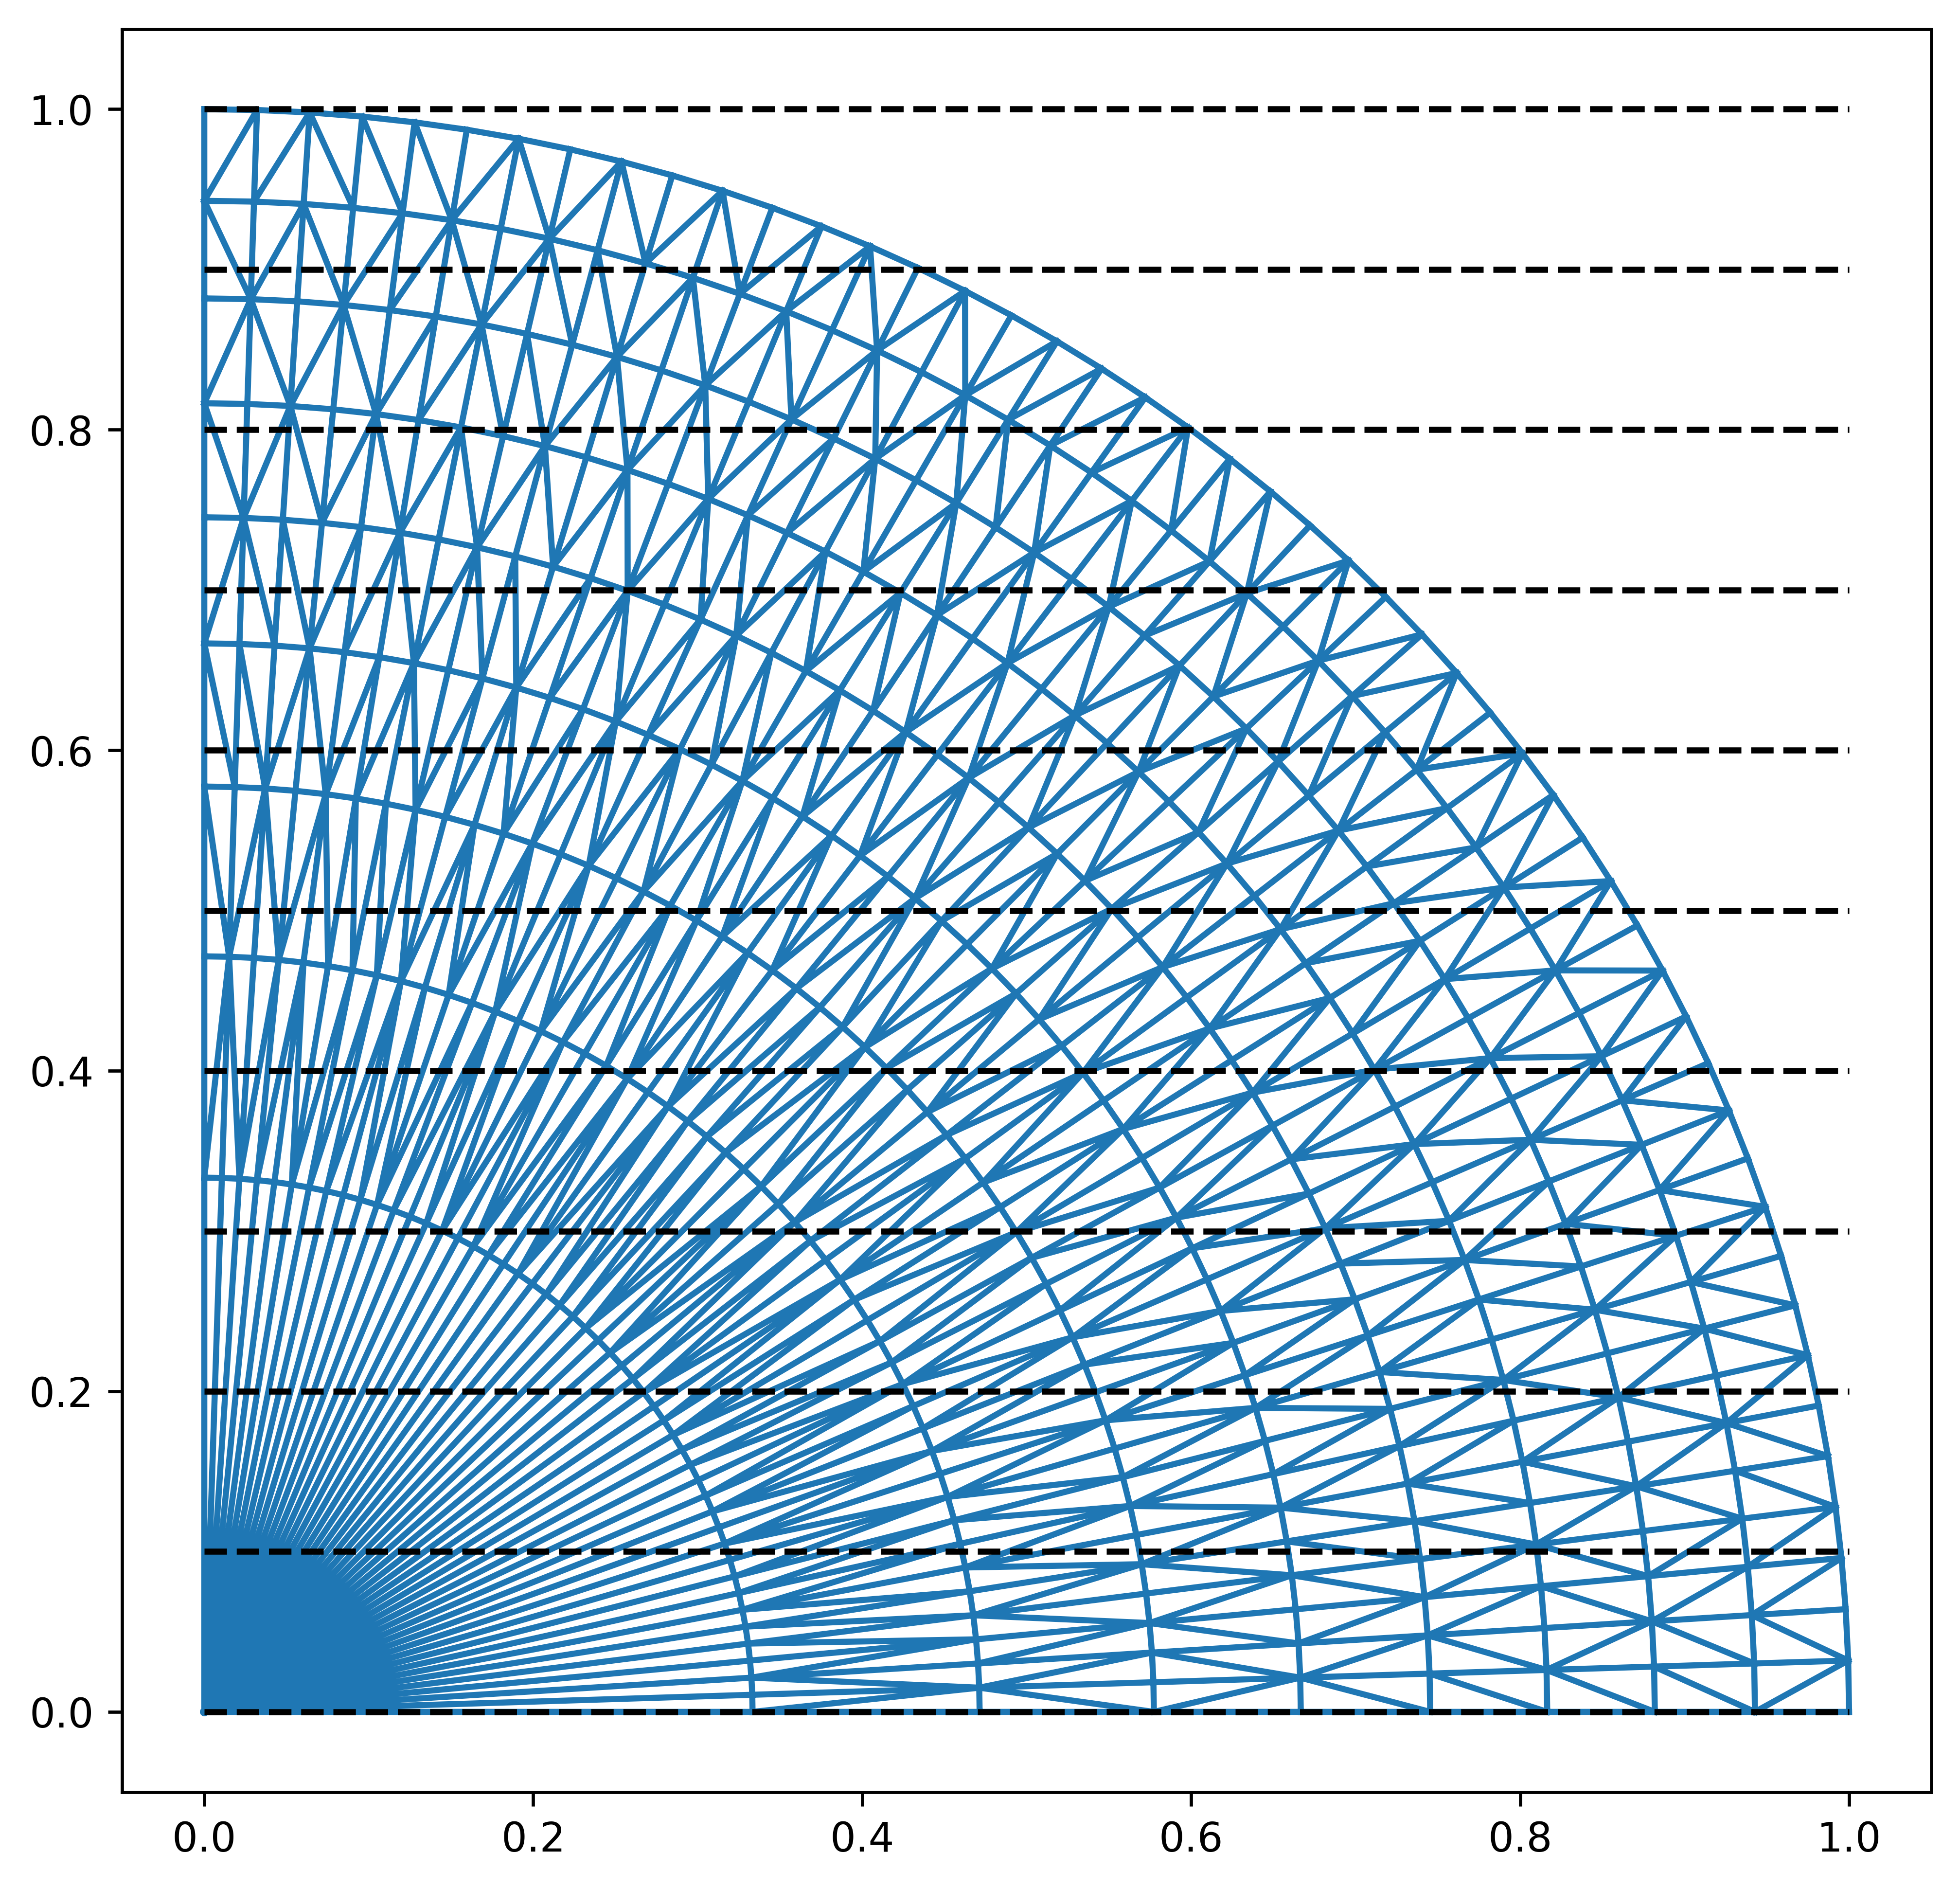

In [44]:
plt.figure(figsize=(8, 8),dpi=600)
plt.scatter(P[:,0],P[:,1],marker = '')
for bound in frame.get_boundaries():
    plt.plot([0,1],[bound,bound],color = 'black', ls = '--')
plt.triplot(circs.triangles)
#plt.scatter(P[0][0],P[0][1],color='red', marker = 'o', s = 50)
#plt.scatter(P[35][0],P[35][1],color='red', marker = 'o', s = 50)
#plt.scatter(P[36][0],P[36][1],color='red', marker = 'o', s = 50)
#plt.scatter(0.54174426, 0.63636364,color='orange',marker='x',s=20)
#plt.scatter(0.52336735, 0.63636364,color='orange',marker='x',s=20)
#plt.xlim(0,0.2)
#plt.ylim(0,0.35)
#plt.savefig('Triangulation')
plt.show()

In [334]:
circs.R

array([0.        , 0.33333333, 0.47140452, 0.57735027, 0.66666667,
       0.74535599, 0.81649658, 0.8819171 , 0.94280904, 1.        ])

In [12]:
with np.printoptions(precision=2, suppress=True):
        print(I)

[[0.   0.   0.   ... 0.04 0.13 0.09]
 [0.   0.   0.   ... 0.16 0.11 0.05]
 [0.   0.   0.   ... 0.09 0.08 0.03]
 ...
 [0.09 0.24 0.11 ... 0.02 0.02 0.01]
 [0.09 0.24 0.11 ... 0.02 0.02 0.01]
 [0.09 0.25 0.11 ... 0.02 0.02 0.01]]


In [13]:
np.linalg.cond(I)

11972.703668568889

## Test Abel transform

In [34]:
# Analytical inverse Abel: 
n = 50
r_max = 1
sigma = 0.5

ref = abel.tools.analytical.GaussianAnalytical(n, r_max, sigma,symmetric=False)

In [35]:
m=100
frame = Image(np.zeros(n),1/n)
circs = Isolines(0,1,n,m)
circs.sample()
P = circs.sample_points_cartesian
circs.triangulate()
I=circs.calculate_matrix_elements(frame)

In [36]:
I.sum()*frame.pixelsize-np.pi/2

-6.590714891641092e-05

In [37]:
func=np.exp(-circs.R**2/sigma**2)

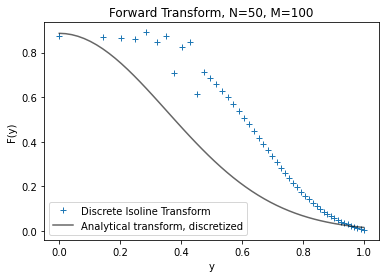

In [38]:
plt.plot(circs.R,np.flip(I@func),marker='+',ms = 6,ls='None',label='Discrete Isoline Transform')
plt.plot(ref.r, ref.abel,color = 'black',alpha=0.6,label='Analytical transform, discretized')
plt.xlabel('y')
plt.ylabel('F(y)')
plt.legend()
plt.title('Forward Transform, N=50, M=100')
#plt.savefig('Gaussian_transformed')
plt.show()

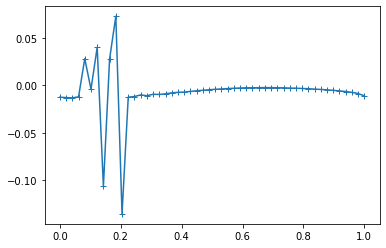

In [39]:
plt.plot(ref.r,(np.flip(I@func)-ref.abel),marker='+')

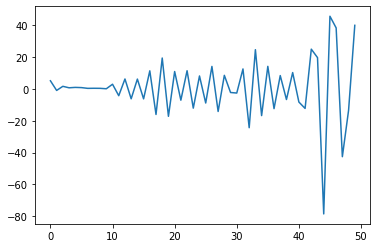

In [41]:
inv = np.linalg.inv(I)
plt.plot(inv@np.flip(ref.abel))

In [42]:
np.linalg.cond(I)

11972.703668568889